# Predicción - Modelo Minecraft

Este notebook carga imágenes desde la carpeta `imagenes_prueba/` y predice si son de Minecraft o no usando el modelo entrenado.

## 1. Importar Librerías

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

## 2. Configurar Dispositivo

In [2]:
# Usar GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3. Definir Arquitectura del Modelo

In [3]:
def crear_modelo(num_clases):
    """
    Crear el modelo ResNet18 con la misma arquitectura del entrenamiento
    """
    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    
    # Reemplazar capa final con arquitectura personalizada
    model.fc = nn.Sequential( #type: ignore
        nn.Dropout(0.5),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_clases)
    )
    
    return model

In [4]:
# Ruta del modelo
MODEL_PATH = Path('./modelos/Modelo_Minecraft.pth')

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"No se encontró el modelo en: {MODEL_PATH}")

num_clases = 3

# Crear y cargar modelo
modelo = crear_modelo(num_clases)
modelo.load_state_dict(torch.load(MODEL_PATH, map_location=device))
modelo = modelo.to(device)
modelo.eval()

C:\Users\Mauricio\AppData\Local\Temp\ipykernel_36124\115093647.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load(MODEL_PATH, map_locatio

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Definir Transformaciones

In [5]:
# Transformaciones para las imágenes de entrada
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 6. Función de Predicción

In [6]:
def predecir_imagen(ruta_imagen, mostrar=True):
    """
    Predecir si una imagen es de Minecraft
    
    Args:
        ruta_imagen: Path a la imagen
        mostrar: Si mostrar la imagen con el resultado
    
    Returns:
        dict con is_minecraft y confianza
    """
    # Cargar imagen
    try:
        imagen = Image.open(ruta_imagen).convert('RGB')
        imagen_original = imagen.copy()
    except Exception as e:
        print(f"ERROR al cargar imagen: {e}")
        return None
    
    # Aplicar transformaciones
    imagen_tensor = transform(imagen).unsqueeze(0).to(device) #type: ignore
    
    # Predecir
    modelo.eval()
    with torch.no_grad():
        salida = modelo(imagen_tensor)
        probabilidades = torch.nn.functional.softmax(salida, dim=1)
        confianza, clase_predicha = torch.max(probabilidades, dim=1)
        confianza = confianza.item()
        clase_predicha = clase_predicha.item()
    
    # Para modelo binario: clase 0 = no_minecraft, clase 1 = minecraft
    es_minecraft = clase_predicha == 1
    
    # Mostrar resultado
    if mostrar:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(imagen_original)
        ax.axis('off')
        
        if es_minecraft:
            titulo = f"MINECRAFT\nConfianza: {confianza*100:.1f}%\nArchivo: {Path(ruta_imagen).name}"
            color = 'green'
        else:
            titulo = f"NO MINECRAFT\nConfianza: {confianza*100:.1f}%\nArchivo: {Path(ruta_imagen).name}"
            color = 'red'
        
        ax.set_title(titulo, fontsize=16, fontweight='bold', color=color, pad=15)
        plt.tight_layout()
        plt.show()
    
    return {
        'es_minecraft': es_minecraft,
        'confianza': confianza,
        'clase': clase_predicha
    }

## 7. Procesar Todas las Imágenes

Procesa automáticamente todas las imágenes en la carpeta `imagenes_prueba/`

PROCESANDO IMÁGENES

Procesando carpeta: imagenes_prueba
Total de imágenes: 15



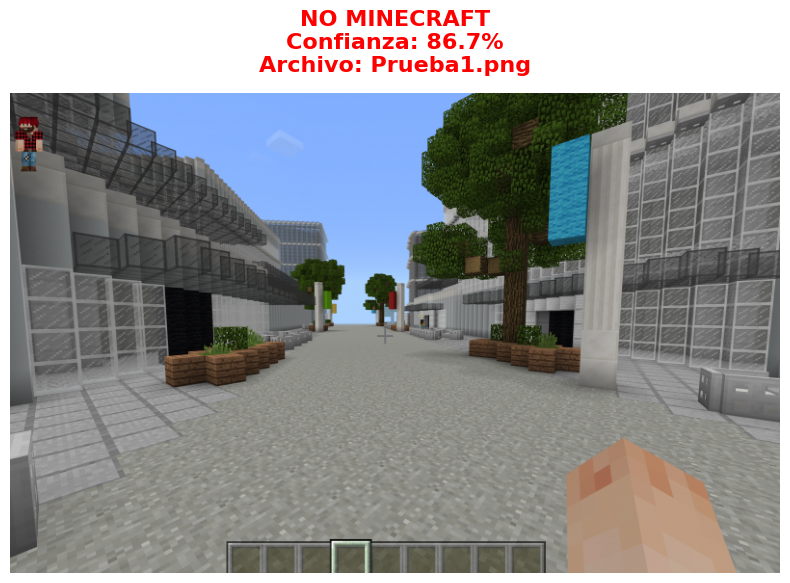

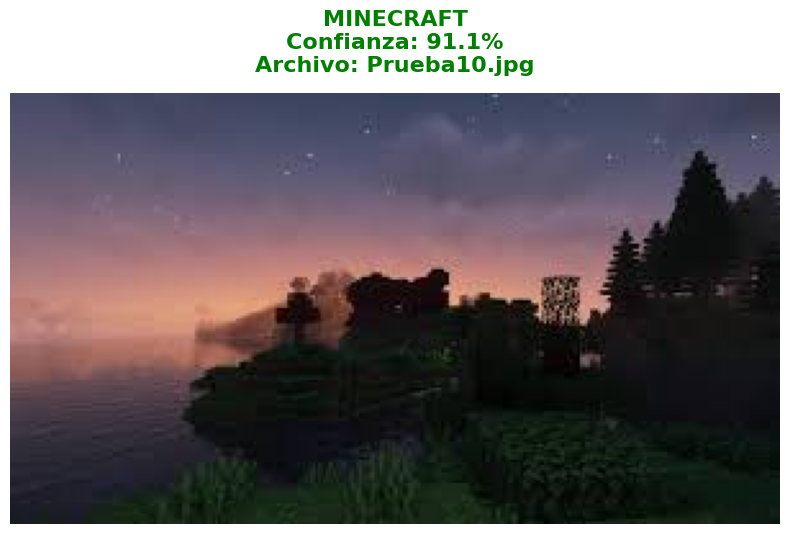

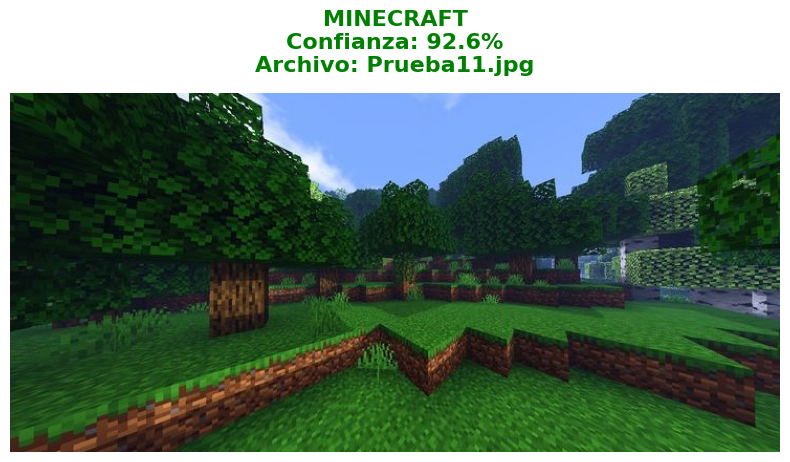

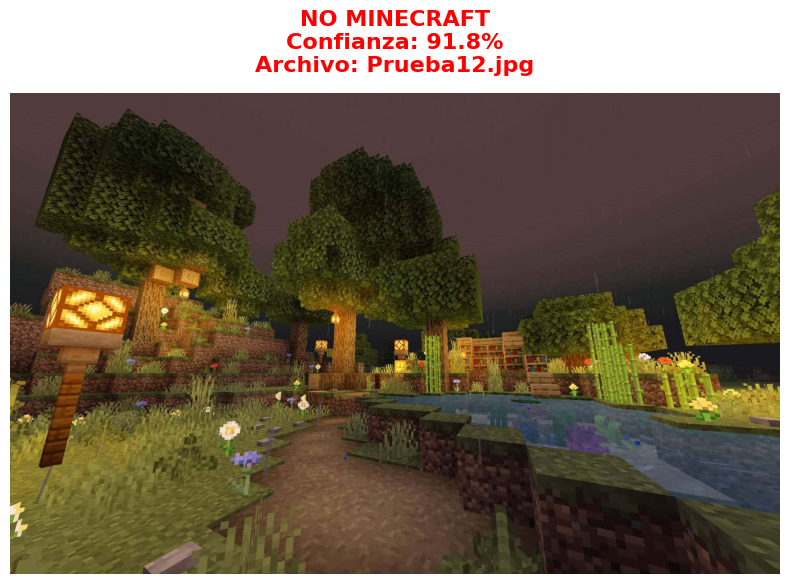

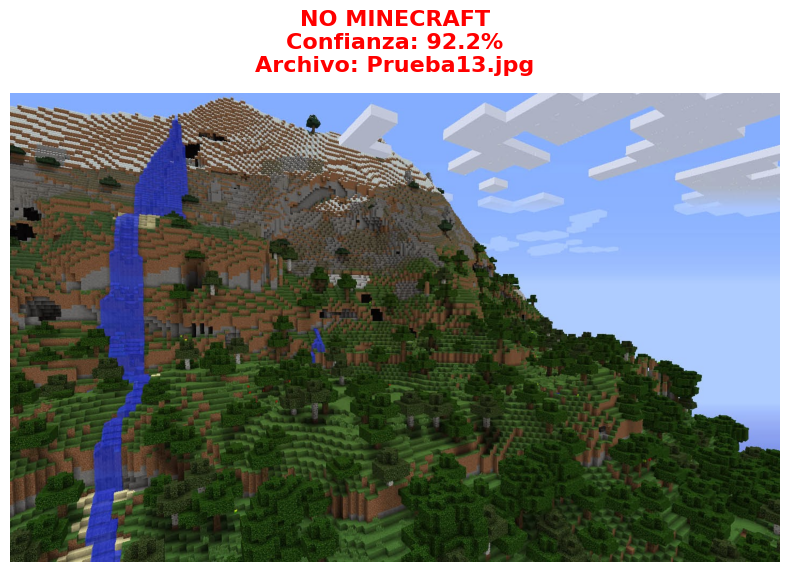

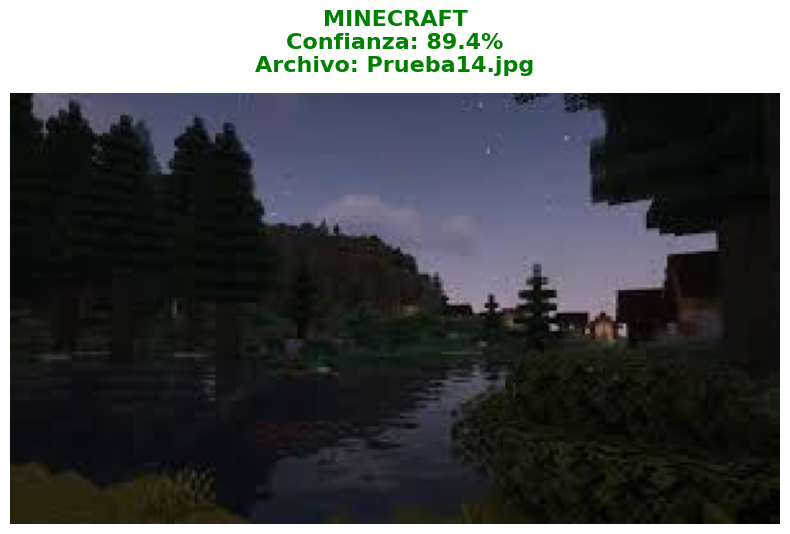

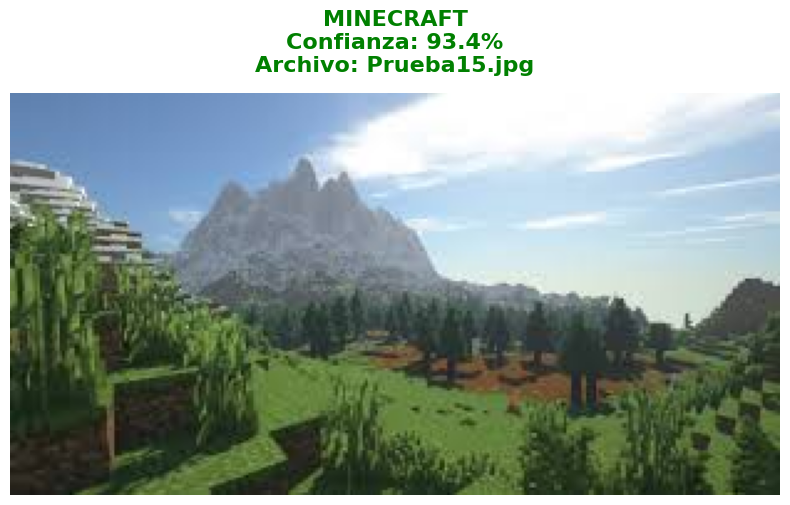

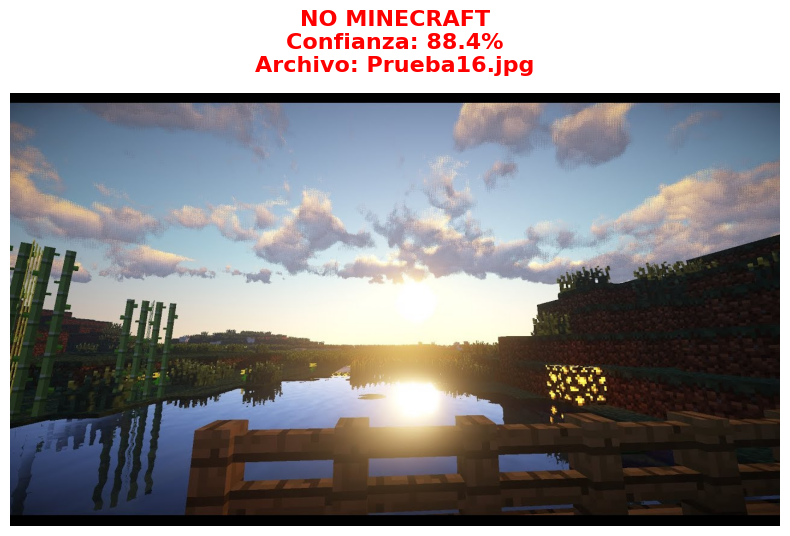

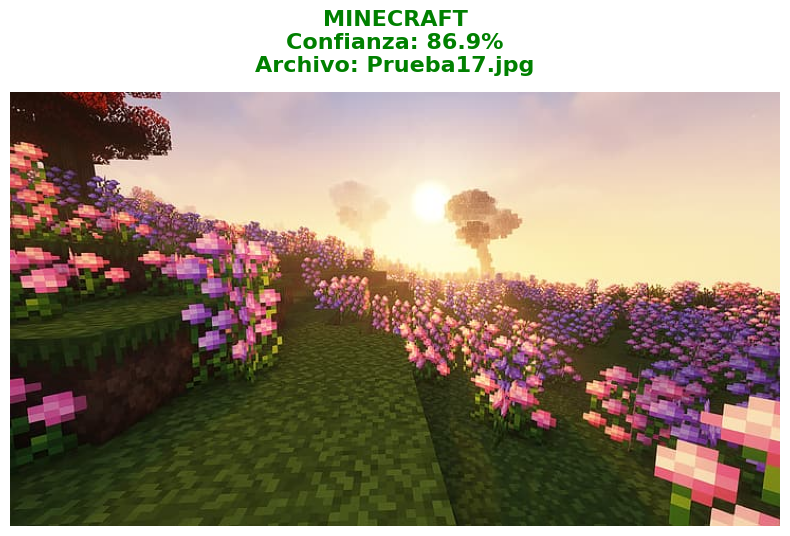

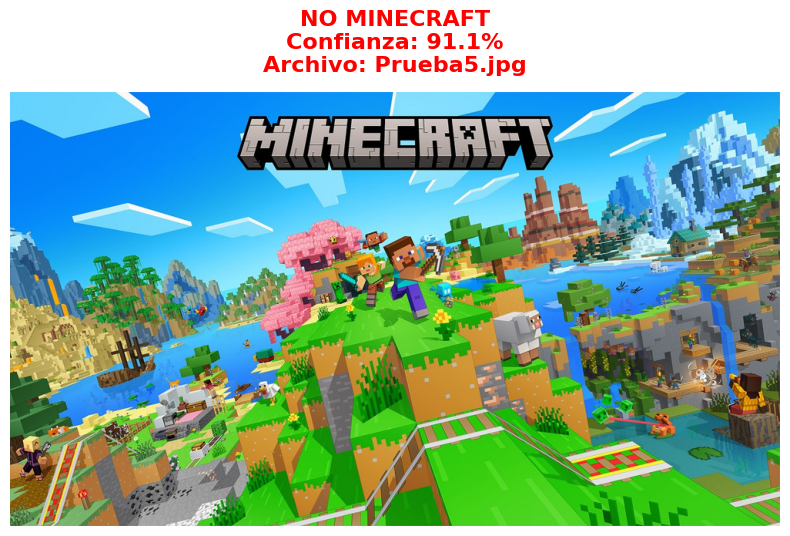

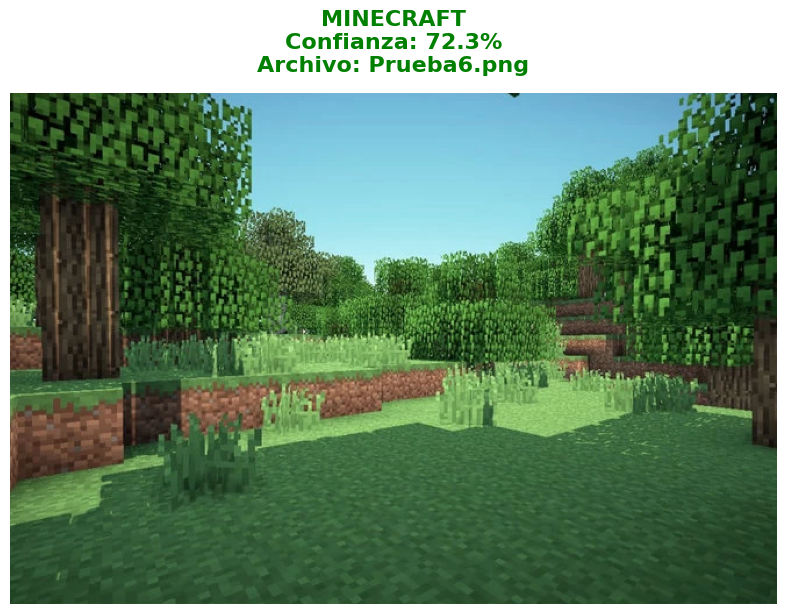

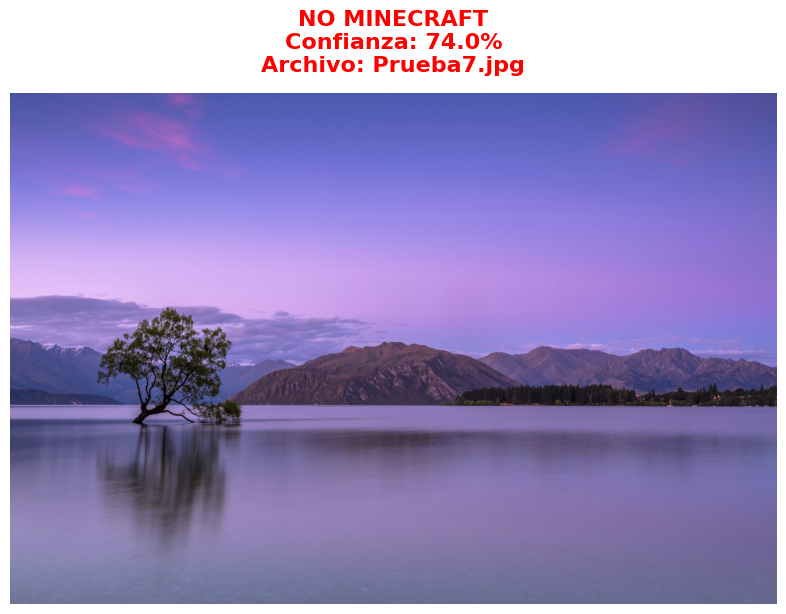

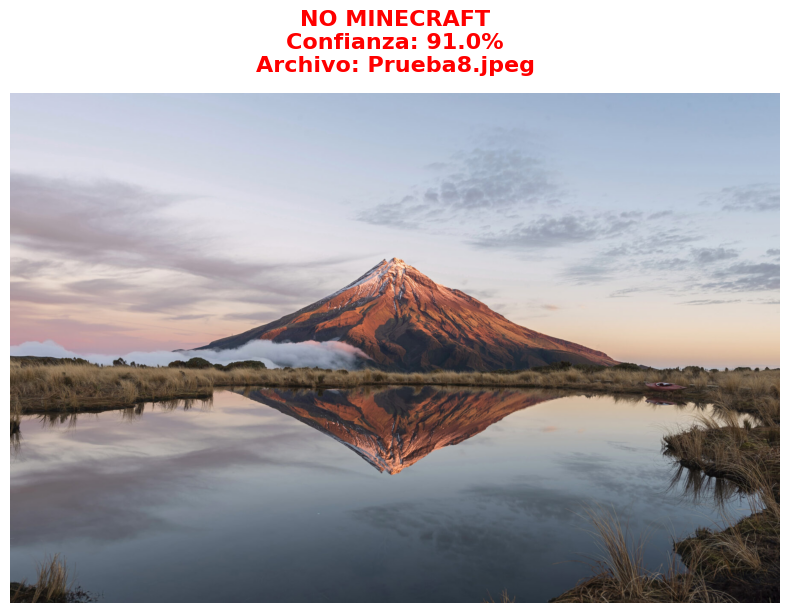

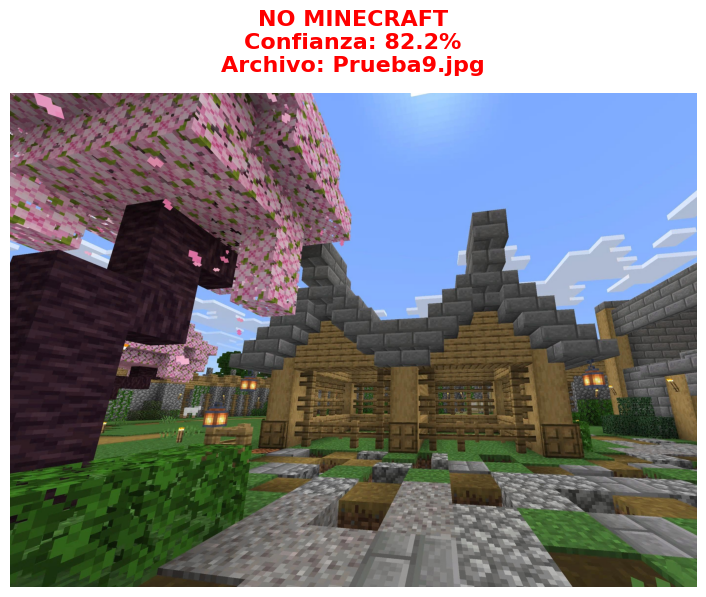

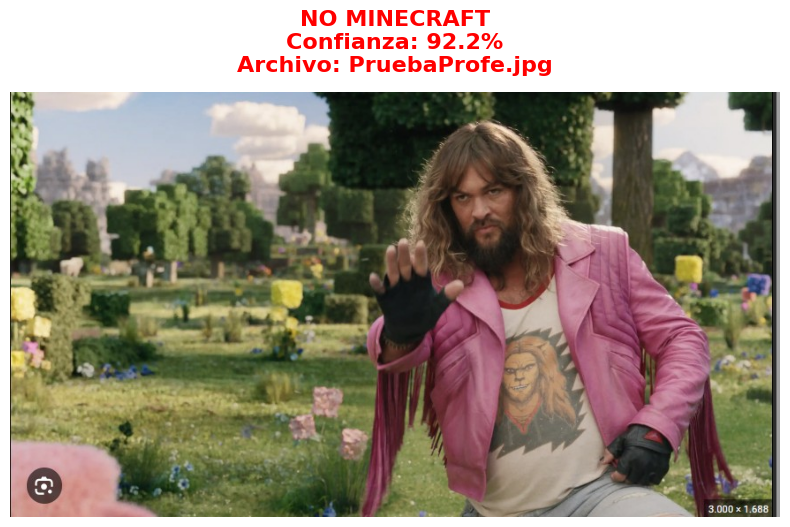

In [7]:
def procesar_carpeta(ruta_carpeta, mostrar_imagenes=True):
    """
    Procesar todas las imágenes en una carpeta
    """
    carpeta = Path(ruta_carpeta)
    
    if not carpeta.exists():
        print(f"ADVERTENCIA: La carpeta no existe: {carpeta}")
        return []
    
    # Buscar archivos de imagen (usando set para evitar duplicados)
    extensiones = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    imagenes_set = set()
    for ext in extensiones:
        imagenes_set.update(carpeta.glob(f'*{ext}'))
        imagenes_set.update(carpeta.glob(f'*{ext.upper()}'))
    
    imagenes = sorted(imagenes_set)  # Convertir a lista ordenada
    
    if len(imagenes) == 0:
        print(f"ADVERTENCIA: No se encontraron imágenes en: {carpeta}")
        print(f"Coloca archivos .jpg, .png, etc. en esta carpeta")
        return []
    
    print(f"\nProcesando carpeta: {carpeta}")
    print(f"Total de imágenes: {len(imagenes)}\n")
    
    resultados = []
    for imagen in imagenes:
        resultado = predecir_imagen(str(imagen), mostrar=mostrar_imagenes)
        if resultado:
            resultados.append({
                'archivo': imagen.name,
                'resultado': resultado
            })
    
    return resultados

# Procesar carpeta de imágenes
print("="*70)
print("PROCESANDO IMÁGENES")
print("="*70)

resultados = procesar_carpeta('./imagenes_prueba', mostrar_imagenes=True)

## 8. Predicción Manual de una Imagen Específica

In [8]:
# Cambia esta ruta por la imagen que quieras probar
ruta_imagen = "imagenes_prueba/mi_imagen.jpg"  

# resultado = predecir_imagen(ruta_imagen, mostrar=True)